# 📘 Aula 5 - Transfer Learning para Classificação de Imagens

![](../../data/imagem/banner-pos-2022.jpg)


## Objetivo

Este notebook apresenta uma aplicação prática de Transfer Learning utilizando um modelo pré-treinado para resolver uma tarefa de classificação de imagens.


## 1. Importação das Bibliotecas

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Tamanho das imagens para entrada da rede
IMAGE_SIZE = (224, 224) 
# Quantidade de imagens por lote 
BATCH_SIZE = 32          
# Número de épocas para treinamento
EPOCHS = 10              
# Caminho da pasta contendo as subpastas 'smile' e 'non_smile'
DATASET_PATH = "../../data/face_emotion" 

os.listdir(DATASET_PATH)

['surprise',
 'disgust',
 'anger',
 'fear',
 'sadness',
 'neutrality',
 'contempt',
 'happiness']

## 2. Preparação dos Dados

In [4]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,  # Separa 20% dos dados para validação
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4449 images belonging to 8 classes.
Found 1109 images belonging to 8 classes.


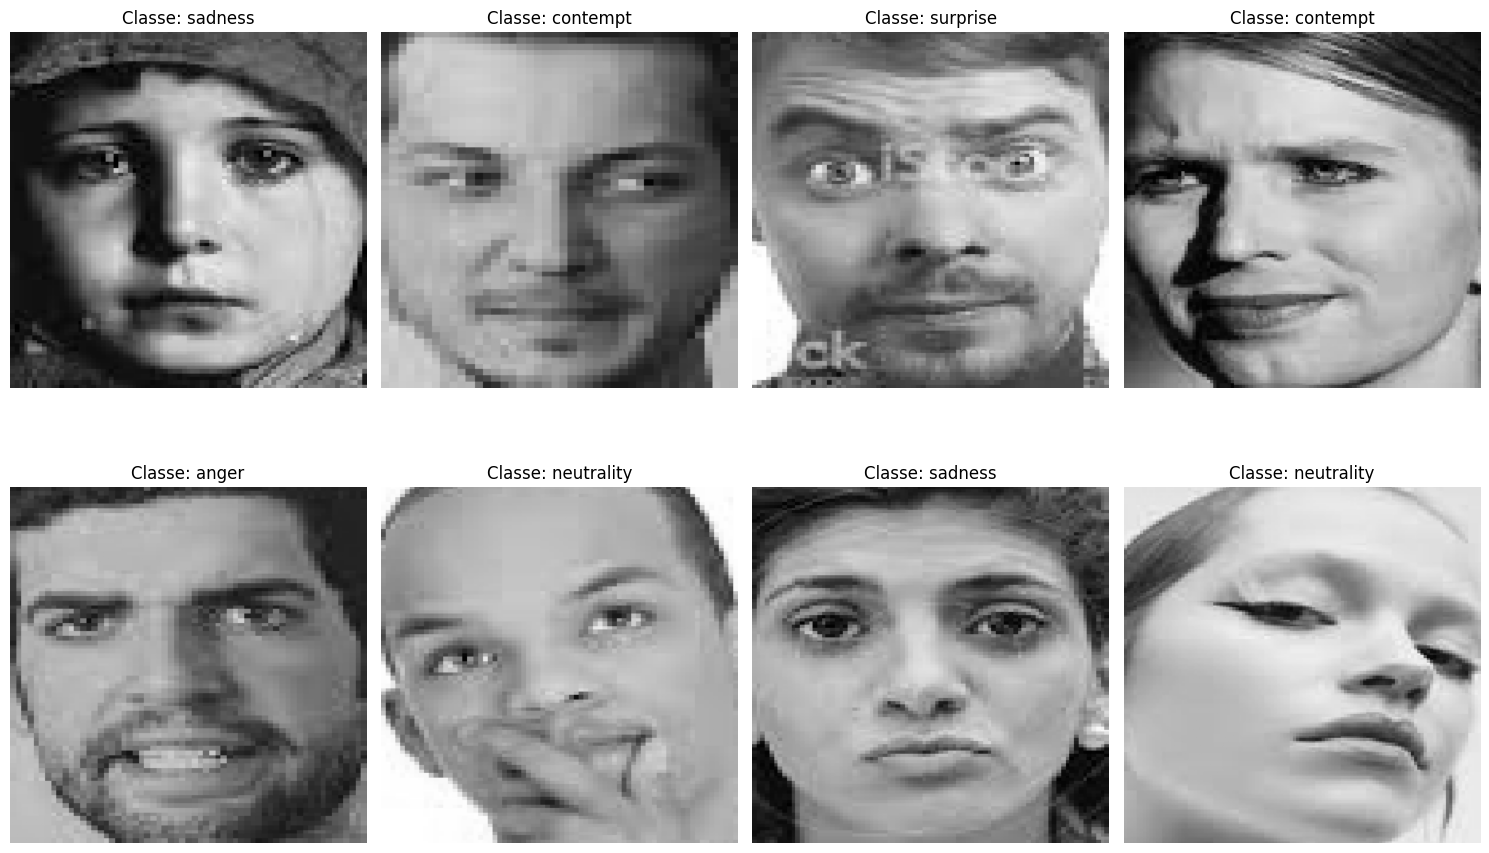

In [5]:
# Obtém um batch de imagens e rótulos do gerador
images, labels = next(train_gen)

# Número de imagens a serem exibidas (máximo do batch_size)
num_images = min(8, len(images))  # Mostra até 8 imagens

# Configura o tamanho da figura
plt.figure(figsize=(15, 10))

# Mapeia índices one-hot para classes (se necessário)
class_indices = train_gen.class_indices
classes = list(class_indices.keys())

for i in range(num_images):
    # Plota a imagem
    plt.subplot(2, 4, i + 1)  # 2 linhas, 4 colunas
    plt.imshow(images[i])
    
    # Obtém o rótulo da imagem (one-hot → classe)
    label_idx = labels[i].argmax()  # Converte one-hot para índice
    label_class = classes[label_idx]  # Obtém o nome da classe
    
    plt.title(f"Classe: {label_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Carregamento do Modelo Pré-treinado (Base)

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congela as camadas convolucionais

## 4. Construção do Modelo com Camadas Personalizadas

In [9]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 5. Treinamento do Modelo

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

/home/octavio/anaconda3/envs/curso_visao_computacional/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-06-20 16:09:28.799170: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-20 16:09:28.837433: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20313600 exceeds 10% of free system memory.
2025-06-20 16:09:28.925414: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-06-20 16:09:29.361220: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2025-06-20 16:09:30.431593: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2193 - loss: 2.0256

140/140 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.2193 - loss: 2.0254 - val_accuracy: 0.2660 - val_loss: 1.9566
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.2310 - loss: 1.9865 - val_accuracy: 0.2534 - val_loss: 1.9630
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2458 - loss: 1.9521

140/140 ━━━━━━━━━━━━━━━━━━━━ 511s 4s/step - accuracy: 0.2458 - loss: 1.9521 - val_accuracy: 0.2543 - val_loss: 1.9556
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2736 - loss: 1.9277

140/140 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.2735 - loss: 1.9278 - val_accuracy: 0.2741 - val_loss: 1.9339
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2730 - loss: 1.9214

140/140 ━━━━━━━━━━━━━━━━━━━━ 535s 4s/step - accuracy: 0.2730 - loss: 1.9215 - val_accuracy: 0.2885 - val_loss: 1.9314
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2662 - loss: 1.9234

140/140 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.2662 - loss: 1.9234 - val_accuracy: 0.2786 - val_loss: 1.9216
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 617s 4s/step - accuracy: 0.2713 - loss: 1.9142 - val_accuracy: 0.2876 - val_loss: 1.9217
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2840 - loss: 1.9078

140/140 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - accuracy: 0.2839 - loss: 1.9078 - val_accuracy: 0.2840 - val_loss: 1.9030
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2781 - loss: 1.9017

140/140 ━━━━━━━━━━━━━━━━━━━━ 529s 4s/step - accuracy: 0.2781 - loss: 1.9017 - val_accuracy: 0.2894 - val_loss: 1.9011
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.2844 - loss: 1.8833 - val_accuracy: 0.2768 - val_loss: 1.9119


## 6. Avaliação do Modelo

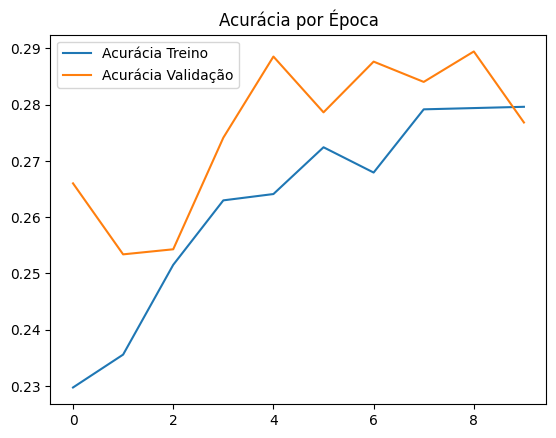

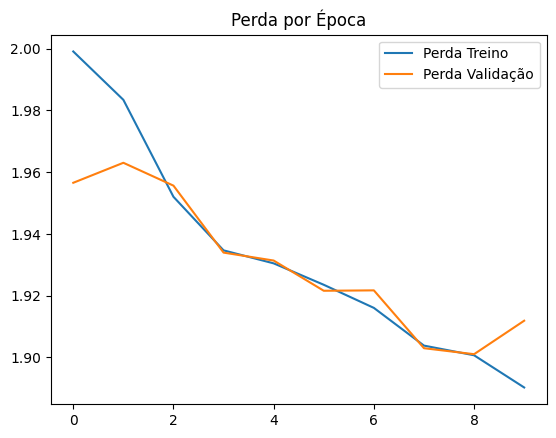

In [11]:
# Curvas de perda e acurácia
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.legend()
plt.title('Acurácia por Época')
plt.show()

plt.plot(history.history['loss'], label='Perda Treino')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.legend()
plt.title('Perda por Época')
plt.show()

## 7. Fine-Tuning (Ajuste Fino - Opcional)
Descongele parte das camadas convolucionais e recompile o modelo para ajustá-las ao seu conjunto de dados.

In [12]:
base_model.trainable = True

# Ajuste fino das últimas camadas
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=10, 
    callbacks=callbacks
)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 617s 4s/step - accuracy: 0.2684 - loss: 2.0349 - val_accuracy: 0.2029 - val_loss: 1.9586
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 621s 4s/step - accuracy: 0.3397 - loss: 1.7475 - val_accuracy: 0.1948 - val_loss: 2.0130
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3627 - loss: 1.6854

140/140 ━━━━━━━━━━━━━━━━━━━━ 633s 5s/step - accuracy: 0.3627 - loss: 1.6853 - val_accuracy: 0.3003 - val_loss: 1.8041
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3920 - loss: 1.6385

140/140 ━━━━━━━━━━━━━━━━━━━━ 642s 5s/step - accuracy: 0.3919 - loss: 1.6384 - val_accuracy: 0.3616 - val_loss: 1.6964
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3925 - loss: 1.5838

140/140 ━━━━━━━━━━━━━━━━━━━━ 646s 5s/step - accuracy: 0.3925 - loss: 1.5838 - val_accuracy: 0.3697 - val_loss: 1.6902
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4050 - loss: 1.5691

140/140 ━━━━━━━━━━━━━━━━━━━━ 674s 5s/step - accuracy: 0.4051 - loss: 1.5691 - val_accuracy: 0.3823 - val_loss: 1.6629
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4353 - loss: 1.5172

140/140 ━━━━━━━━━━━━━━━━━━━━ 643s 5s/step - accuracy: 0.4353 - loss: 1.5172 - val_accuracy: 0.4013 - val_loss: 1.6371
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4549 - loss: 1.4797

140/140 ━━━━━━━━━━━━━━━━━━━━ 637s 5s/step - accuracy: 0.4549 - loss: 1.4798 - val_accuracy: 0.4085 - val_loss: 1.6097
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 665s 5s/step - accuracy: 0.4717 - loss: 1.4415 - val_accuracy: 0.3814 - val_loss: 1.6766
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4673 - loss: 1.4502

140/140 ━━━━━━━━━━━━━━━━━━━━ 641s 5s/step - accuracy: 0.4673 - loss: 1.4501 - val_accuracy: 0.4130 - val_loss: 1.6067


## 8. Inferência

In [52]:
import cv2
import random

class_indices = train_gen.class_indices
class_names = {v: k for k, v in class_indices.items()}

In [53]:
class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happiness': 4,
 'neutrality': 5,
 'sadness': 6,
 'surprise': 7}

### 8.1 Pré-processamento

In [54]:
labels = sorted(os.listdir(DATASET_PATH))

In [57]:
def select_random_image_path(label):    
    img_name = random.choice(os.listdir(os.path.join(DATASET_PATH, label)))
    return os.path.join(DATASET_PATH, label, img_name)

# Função para pré-processar a imagem (OpenCV)
def prepare_image_cv(img_rgb):
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def image_read(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def inference(img, model):
    img_array = prepare_image_cv(img)
    prob = model.predict(img_array, verbose=False)[0][0]
    pred_class = np.argmax(prob)
    confidence = np.max(prob)    

    return pred_class, confidence


### 8.2 Load Model

In [58]:
from tensorflow.keras.models import load_model

In [59]:
model = load_model('best_model.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,018 (90.98 MB)

 Trainable params: 4,728,968 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

### 8.3 Visualizando a predição do modelo

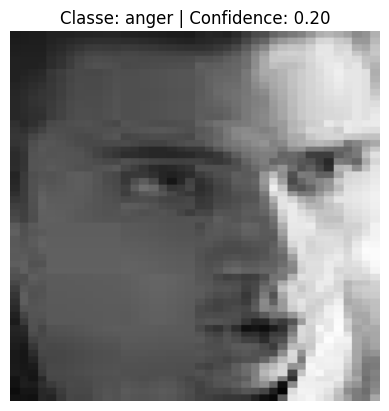

In [65]:
img_path = select_random_image_path(label=labels[0])
img = image_read(img_path)

pred_class, confidence = inference(img, model)

plt.imshow(img)
plt.axis('off')
plt.title(f"Classe: {class_names[pred_class]} | Confidence: {confidence:.2f}")
plt.show()